## Complete Tiling and Decision Boundary [Part 1]

- Ok, simple goal here
- For my widest and deepest models [let's say 1024 and 32x32x32x32 for now], I need to be able to compute all my surfaces, tilings, and final decision boundary all the way through with no gaps or issues.
- The code to make this work seems non-trivial -> i'm getting close in manim but am getting gaps with the big model
- Shifting to here for now to make this work
- The viz I develop here can also be used for my preliminary training animations

In [15]:
from manimlib import *
from functools import partial
import sys

sys.path.append('../_2025/backprop_3') #Point to folder where plane_folding_utils.py is
sys.path.append('../')
from geometric_dl_utils import *
from polytope_intersection_utils import intersect_polytopes
import matplotlib.pyplot as plt

In [63]:
#2x2
# model_path='../models/2_2_1.pth'
# model = BaarleNet([2,2])
# model.load_state_dict(torch.load(model_path))
# viz_scales=[0.25, 0.25, 0.3, 0.3, 0.15]
# num_neurons=[2, 2, 2, 2, 2]

### 16 16 16
model_path='../models/16_16_16_1.pth'
model = BaarleNet([16, 16, 16])
model.load_state_dict(torch.load(model_path))
num_neurons=[16, 16, 16, 16, 16, 16, 2]        

### 32 32 32 32
# model_path='../models/32_32_32_32_1.pth'
# model = BaarleNet([32, 32, 32])
# model.load_state_dict(torch.load(model_path))
# num_neurons=[32, 32, 32, 32, 32, 32, 32, 32, 2]        

In [64]:
graphics_dir='/Users/stephen/Stephencwelch Dropbox/welch_labs/backprop_3/graphics/' #Point to folder where map images are
heatmaps_dir='/Users/stephen/Stephencwelch Dropbox/welch_labs/backprop_3/hackin/heatmaps'

Trying to decide if I want to decouple my viz pipelines from computational piplines -> not sure yet!

In [65]:
vertical_spacing=1.5
horizontal_spacing=3
colors = [BLUE, RED, GREEN, YELLOW, PURPLE, ORANGE, PINK, TEAL]

# Hmm ok I think I need to compute a different viz scale for each surface probably 
# I don't want to totally normalize the heights though, ya know?
# Maybe there's a discrete set of possible viz scales: 
adaptive_viz_scales = compute_adaptive_viz_scales(model, max_surface_height=1.0, extent=1)
#For the interesection to make sense, these scales need to match - either need to manual overide or chnage method above
final_layer_viz=scale=2*min(adaptive_viz_scales[-1]) #little manual ramp here
adaptive_viz_scales[-1]=[final_layer_viz, final_layer_viz]


surfaces=[]
surface_funcs=[]
surface_funcs_no_viz_scale=[]
for layer_idx in range(len(model.model)):
    s=Group()
    surface_funcs.append([])
    surface_funcs_no_viz_scale.append([])
    for neuron_idx in range(num_neurons[layer_idx]):
        surface_func=partial(surface_func_from_model, model=model, layer_idx=layer_idx, neuron_idx=neuron_idx, viz_scale=adaptive_viz_scales[layer_idx][neuron_idx])
        surface_func_no_scaling=partial(surface_func_from_model, model=model, layer_idx=layer_idx, neuron_idx=neuron_idx, viz_scale=1.0) #adaptive_viz_scales[layer_idx][neuron_idx])
        bent_surface = ParametricSurface(surface_func, u_range=[-1, 1], v_range=[-1, 1], resolution=(64, 64))
        ts=TexturedSurface(bent_surface, graphics_dir+'/baarle_hertog_maps/baarle_hertog_maps-11.png')
        ts.set_shading(0,0,0).set_opacity(0.75)
        s.add(ts)
        surface_funcs[-1].append(surface_func)
        surface_funcs_no_viz_scale[-1].append(surface_func_no_scaling)
    surfaces.append(s)


In [66]:
layer_idx=1
layer_1_polygons=get_polygon_corners_layer_1(model)
layer_1_polygons_3d=get_3d_polygons_layer_1(layer_1_polygons, surface_funcs_no_viz_scale, num_neurons=num_neurons[layer_idx], layer_idx=1)

In [67]:
from matplotlib.patches import Polygon
tab20_colors_mpl = plt.cm.tab20.colors

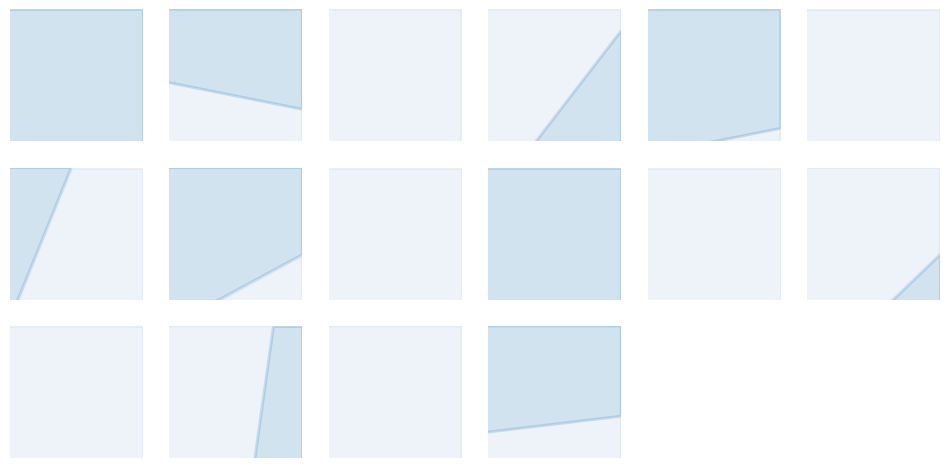

In [70]:
fig=plt.figure(0, (12,12))
for i, polygons in enumerate(layer_1_polygons_3d):
    ax=fig.add_subplot(6,6,i+1)
    for j, polygon in enumerate(polygons):
        if len(polygon)<3: continue
        poly=Polygon(polygon[:,:2].tolist(), facecolor=tab20_colors_mpl[j%len(tab20_colors_mpl)], edgecolor=tab20_colors_mpl[j%len(tab20_colors_mpl)], linewidth=2, alpha=0.2)
        ax.add_patch(poly)
        plt.axis('off')

Sweet - now we tile these together!

In [71]:
layer_2_polygons=carve_plane_with_relu_joints([o['relu_line'] for o in layer_1_polygons])

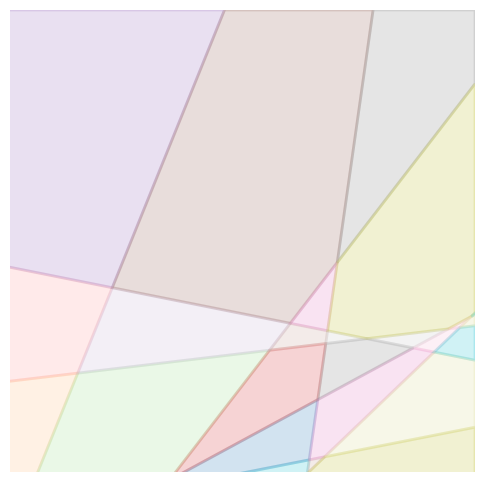

In [72]:
fig=plt.figure(0, (6,6))
ax=fig.add_subplot(111)
for j, polygon in enumerate(layer_2_polygons):
    poly=Polygon(polygon, facecolor=tab20_colors_mpl[j%len(tab20_colors_mpl)], edgecolor=tab20_colors_mpl[j%len(tab20_colors_mpl)], linewidth=2, alpha=0.2)
    ax.add_patch(poly)
    plt.axis('off')

In [73]:
layer_idx=2
layer_2_polygons_3d=get_3d_polygons(layer_2_polygons, num_neurons[layer_idx], surface_funcs_no_viz_scale, layer_idx)

layer_idx=3
all_polygons, merged_zero_polygons, unmerged_polygons = split_polygons_with_relu(layer_2_polygons_3d)
all_polygons_after_merging=copy.deepcopy(merged_zero_polygons)
for i, o in enumerate(unmerged_polygons):
    all_polygons_after_merging[i].extend(o)

all_polygons_after_merging_2d=[]
for p in all_polygons_after_merging:
    pd2=[o[:,:2] for o in p]
    all_polygons_after_merging_2d.append(pd2)

layer3_regions_2d = find_polygon_intersections(all_polygons_after_merging_2d)

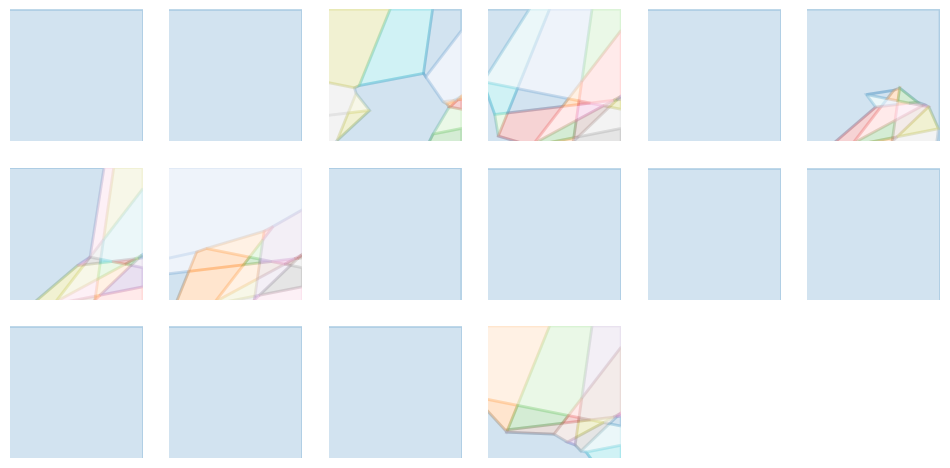

In [74]:
fig=plt.figure(0, (12,12))
for i, polygons in enumerate(all_polygons_after_merging):
    ax=fig.add_subplot(6,6,i+1)
    for j, polygon in enumerate(polygons):
        poly=Polygon(polygon[:,:2].tolist(), facecolor=tab20_colors_mpl[j%len(tab20_colors_mpl)], edgecolor=tab20_colors_mpl[j%len(tab20_colors_mpl)], linewidth=2, alpha=0.2)
        ax.add_patch(poly)
        plt.axis('off')

In [53]:
# layer_2_polygons_3d
# all_polygons

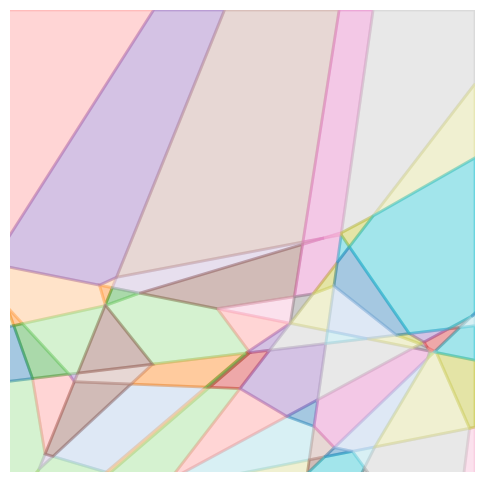

In [75]:
fig=plt.figure(0, (6,6))
ax=fig.add_subplot(111)
for j, polygon in enumerate(layer3_regions_2d):
    poly=Polygon(polygon, facecolor=tab20_colors_mpl[j%len(tab20_colors_mpl)], edgecolor=tab20_colors_mpl[j%len(tab20_colors_mpl)], linewidth=2, alpha=0.4)
    ax.add_patch(poly)
    plt.axis('off')

In [ ]:
layer_idx=4
layer_2_polygons_3d=get_3d_polygons(layer3_regions_2d, num_neurons[layer_idx], surface_funcs_no_viz_scale, layer_idx)

layer_idx=5
all_polygons, merged_zero_polygons, unmerged_polygons = split_polygons_with_relu(layer_2_polygons_3d)
all_polygons_after_merging=copy.deepcopy(merged_zero_polygons)
for i, o in enumerate(unmerged_polygons):
    all_polygons_after_merging[i].extend(o)

all_polygons_after_merging_2d=[]
for p in all_polygons_after_merging:
    pd2=[o[:,:2] for o in p]
    all_polygons_after_merging_2d.append(pd2)

layer3_regions_2d = find_polygon_intersections(all_polygons_after_merging_2d)

In [ ]:
fig=plt.figure(0, (12,12))
for i, polygons in enumerate(all_polygons_after_merging):
    ax=fig.add_subplot(6,6,i+1)
    for j, polygon in enumerate(polygons):
        poly=Polygon(polygon[:,:2].tolist(), facecolor=tab20_colors_mpl[j%len(tab20_colors_mpl)], edgecolor=tab20_colors_mpl[j%len(tab20_colors_mpl)], linewidth=2, alpha=0.2)
        ax.add_patch(poly)
        plt.axis('off')

In [ ]:
fig=plt.figure(0, (6,6))
ax=fig.add_subplot(111)
for j, polygon in enumerate(layer3_regions_2d):
    poly=Polygon(polygon, facecolor=tab20_colors_mpl[j%len(tab20_colors_mpl)], edgecolor=tab20_colors_mpl[j%len(tab20_colors_mpl)], linewidth=2, alpha=0.4)
    ax.add_patch(poly)
    plt.axis('off')

- Ok cool - yeah kind afeel like I want to do some refactoring on the manim side? 
- I guess I feel like the iteration loop could be tighter
- Yeah I think I basically need to decide if I want to decouple things a bit -> i think that makes a ton of thesen if things are like not working. 